In [3]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [184]:
## Ensure the correct working directory

import numpy as np
import spikeinterface as si
import intanrhdreader
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory
from scipy import signal, stats
from matplotlib import pyplot as plt

from workflow.pipeline import culture, ephys, probe, analysis

In [32]:
# Initial Variables
path = "D:\\"
filenames = ["processed_O9-12_230518_010006.rhd", "processed_O13-16_230608_010042.rhd","processed_O17-20_230712_010046.rhd"]

POWERLINE_NOISE_FREQ = 60
TARGET_SAMPLING_RATE = 2500

In [215]:
folder_to_organoid_id = {
    "O09-12_raw": ["O9", "O10", "O11", "O12"],
    "O13-16_raw": ["O13", "O14", "O15", "O16"],
    "O17-20_raw": ["O17", "O18", "O19", "O20"]
}
organoid_to_filename = {
    "O09": f"O09-12_raw/{filenames[0]}",
    "O10": f"O09-12_raw/{filenames[0]}",
    "O11": f"O09-12_raw/{filenames[0]}",
    "O12": f"O09-12_raw/{filenames[0]}",
    "O13": f"O13-16_raw/{filenames[1]}",
    "O14": f"O13-16_raw/{filenames[1]}",
    "O15": f"O13-16_raw/{filenames[1]}",
    "O16": f"O13-16_raw/{filenames[1]}",
    "O17": f"O17-20_raw/{filenames[2]}",
    "O18": f"O17-20_raw/{filenames[2]}",
    "O19": f"O17-20_raw/{filenames[2]}",
    "O20": f"O17-20_raw/{filenames[2]}",
}
organoid_to_num_elec = {
    "O09": 32,
    "O10": 16,
    "O11": 20,
    "O12": 14,
    "O13": 25,
    "O14": 13,
    "O15": 11,
    "O16": 11,
    "O17": 18,
    "O18": 21,
    "O19": 22,
    "O20": 23
}

is_chimera = {
    "O09": False,
    "O10": False,
    "O11": False,
    "O12": False,
    "O13": False,
    "O14": False,
    "O15": False,
    "O16": False,
    "O17": True,
    "O18": True,
    "O19": True,
    "O20": True,
}

window_size = 1.0
overlap_size = .25
frequency_window = [30, 50]

data_dict = {
    "power": {},
    "slope_intercept": {}
}

In [216]:
# Fetch the probe information for the given ephys session
probe_info = (ephys.EphysSessionProbe & key).fetch1()
probe_type = (probe.Probe & {"probe": probe_info["probe"]}).fetch1("probe_type")
electrode_query = probe.ElectrodeConfig.Electrode & (
    probe.ElectrodeConfig & {"probe_type": probe_type}
)

# Fetch the electrode configuration for the given probe
# Filter for used electrodes. If probe_info["used_electrodes"] is None, it means all electrodes were used.
if probe_info["used_electrodes"]:
    electrode_query &= f"electrode IN {tuple(probe_info['used_electrodes'])}"

lfp_indices = np.array(electrode_query.fetch("channel_idx"), dtype=int)

electrode_df = electrode_query.fetch(format="frame").reset_index()

[2025-06-10 21:58:45,935][WARNING]: MySQL server has gone away. Reconnecting to the server.


In [217]:
for org_id in list(organoid_to_filename.keys()):
    
    # load data
    file = organoid_to_filename[org_id]
    filepath = os.path.join(path, file)
    try:
        print(f"for {org_id}: loading {file}")
        data = intanrhdreader.load_file(filepath)
    except OSError:
        raise OSError(f"OS error occurred when loading file {filepath.name}")

    # get key
    key = (ephys.EphysSession & f"organoid_id = '{org_id}'" & "session_type = 'lfp'").fetch("KEY")[0]

    # Fetch the probe information for the given ephys session
    probe_info = (ephys.EphysSessionProbe & key).fetch1()
    probe_type = (probe.Probe & {"probe": probe_info["probe"]}).fetch1("probe_type")
    electrode_query = probe.ElectrodeConfig.Electrode & (
        probe.ElectrodeConfig & {"probe_type": probe_type}
    )

    # Fetch the electrode configuration for the given probe
    # Filter for used electrodes. If probe_info["used_electrodes"] is None, it means all electrodes were used.
    if probe_info["used_electrodes"]:
        electrode_query &= f"electrode IN {tuple(probe_info['used_electrodes'])}"

    lfp_indices = np.array(electrode_query.fetch("channel_idx"), dtype=int)

    electrode_df = electrode_query.fetch(format="frame").reset_index()

    # get data
    header = data.pop("header")
    lfp_sampling_rate = header["sample_rate"]
    powerline_noise_freq = (
        POWERLINE_NOISE_FREQ
    )  

    # Calculate downsampling factor
    true_ratio = lfp_sampling_rate / TARGET_SAMPLING_RATE
    downsample_factor = int(np.round(true_ratio))

    # Check if the ratio is within 1% of an integer (1% tolerance)
    if not np.isclose(true_ratio, downsample_factor, rtol=0.01, atol=1e-8):
        raise ValueError(
            f"Downsampling factor {true_ratio} is too far from an integer. Check LFP sampling rates."
        )

    # Get LFP indices (row index of the LFP matrix to be used)
    port_indices = np.array(
        [
            ind
            for ind, ch in enumerate(data["amplifier_channels"])
            if ch["port_prefix"] == probe_info["port_id"]
        ]
    )
    lfp_indices = np.sort(port_indices[lfp_indices])
    lfp_indices = lfp_indices[:organoid_to_num_elec[org_id]]

    # Get LFP channels
    channels = np.array(
        [
            ch["native_channel_name"]
            for ch in data["amplifier_channels"]
            if ch["port_prefix"]
        ]
    )[lfp_indices]

    # Get channel to electrode mapping
    channel_to_electrode_map = dict(
        zip(electrode_df["channel_idx"], electrode_df["electrode"])
    )

    channel_to_electrode_map = {
        f'{probe_info["port_id"]}-{int(channel):03d}': electrode
        for channel, electrode in channel_to_electrode_map.items()
    }

    data_array = data.pop("amplifier_data")[lfp_indices]

    # Design notch filter
    notch_b, notch_a = signal.iirnotch(
        w0=powerline_noise_freq, Q=30, fs=lfp_sampling_rate
    )

    power_array = []
    coeff_array = []
    for ch_idx, raw_trace in zip(channels, data_array):
        # Apply notch filter
        trace = signal.filtfilt(notch_b, notch_a, raw_trace)

        # Downsample the signal with `decimate`
        trace = signal.decimate(trace, downsample_factor, ftype="fir", zero_phase=True)

        frequency, time, Sxx = signal.spectrogram(
            trace,
            fs=int(TARGET_SAMPLING_RATE),
            nperseg=int(window_size * TARGET_SAMPLING_RATE),
            noverlap=int(overlap_size * TARGET_SAMPLING_RATE),
            window="hamming",
        )
        
        target = (frequency_window[0] <= frequency) & (frequency <= frequency_window[1])

        target_freq = frequency[target]
        target_power = np.mean(Sxx[target,:], axis=1)

        coeffs = np.polyfit(np.log(target_freq), np.log(target_power), 1)

        power_array.append(target_power)
        coeff_array.append(coeffs)
    power_array = np.array(power_array)
    coeff_array = np.array(coeff_array)

    data_dict["power"][org_id] = power_array
    data_dict["slope_intercept"][org_id] = coeff_array


    


for O09: loading O09-12_raw/processed_O9-12_230518_010006.rhd
for O10: loading O09-12_raw/processed_O9-12_230518_010006.rhd
for O11: loading O09-12_raw/processed_O9-12_230518_010006.rhd
for O12: loading O09-12_raw/processed_O9-12_230518_010006.rhd
for O13: loading O13-16_raw/processed_O13-16_230608_010042.rhd
for O14: loading O13-16_raw/processed_O13-16_230608_010042.rhd
for O15: loading O13-16_raw/processed_O13-16_230608_010042.rhd
for O16: loading O13-16_raw/processed_O13-16_230608_010042.rhd
for O17: loading O17-20_raw/processed_O17-20_230712_010046.rhd
for O18: loading O17-20_raw/processed_O17-20_230712_010046.rhd
for O19: loading O17-20_raw/processed_O17-20_230712_010046.rhd
for O20: loading O17-20_raw/processed_O17-20_230712_010046.rhd


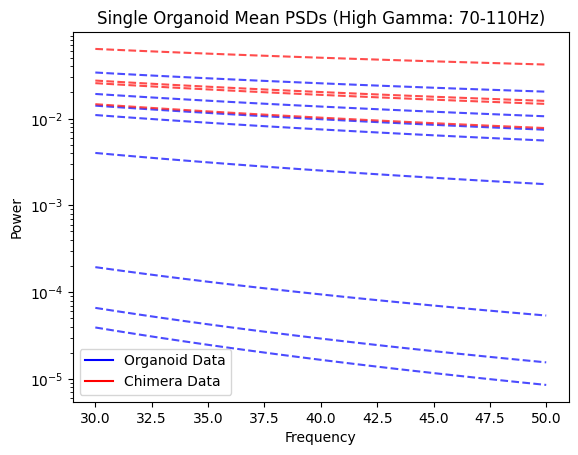

In [ ]:
power_dict = data_dict["power"]
coeff_dict = data_dict["slope_intercept"]
f = target_freq

plt.figure()

for organoid_id in list(organoid_to_filename.keys()):

    power_values = power_dict[organoid_id]
    coeff_values = coeff_dict[organoid_id]
    N = power_values.shape[1]   

    # get power values
    power_mean = np.mean(power_values, axis=0)
    power_std = np.std(power_values, axis=0)

    # get fit
    x, b = np.mean(coeff_values, axis=0)
    fit = f**x
    
    if is_chimera[organoid_id]:
        color = "r"
    else:
        color = "b"

    plt.plot(f, power_mean, color=color, linestyle="-", alpha=.7)
    # plt.fill_between(f, 
    #                  power_mean-power_std,
    #                  power_mean+power_std,
    #                  color=color,
    #                  alpha=.1)

    # plt.plot(f,fit, color=color, linestyle="--", alpha=.7)

plt.title("Single Organoid Mean PSDs (High Gamma: 70-110Hz)")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.yscale("log")

plt.plot([], color="b", linestyle="-", label="Organoid Data")
# plt.plot([], color="b", linestyle="--", label="Organoid Fit")
plt.plot([], color="r", linestyle="-", label="Chimera Data")
# plt.plot([], color="r", linestyle="--", label="Chimera Fit")
plt.legend()

Text(-8.15, 1.1, 'n1=142 organoid electrodes \nn2=84 chimera electrodes \n 2-sample t-test pvalue: 1.486e-10')

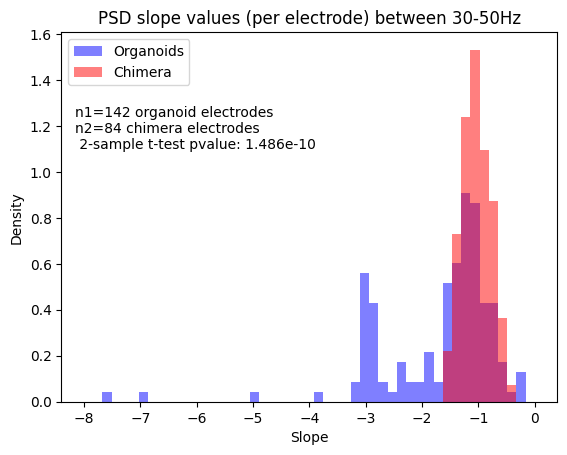

In [219]:
coeff_dict = data_dict["slope_intercept"]
f = target_freq

plt.figure()

organoid_data = []
chimera_data = []
for organoid_id in list(organoid_to_filename.keys()):

    slope_values = coeff_dict[organoid_id][:,0]
    
    if is_chimera[organoid_id]:
        chimera_data.extend(list(slope_values))
    else:
        organoid_data.extend(list(slope_values))

x = np.linspace(-8, 0, 50)
plt.hist(organoid_data, x, color="b", label="Organoids", density=True, alpha=.5)
plt.hist(chimera_data, x, color="r", label="Chimera", density=True, alpha=.5)

plt.title("PSD slope values (per electrode) between 30-50Hz")
plt.xlabel("Slope")
plt.ylabel("Density")
plt.legend()
plt.text(x=-8.15, y=1.1, s=f"n1={len(organoid_data)} organoid electrodes \nn2={len(chimera_data)} chimera electrodes \n 2-sample t-test pvalue: 1.486e-10")

In [220]:
# determine if organoid and chimera data has equal variance
print(f"organoid std: {np.std(organoid_data)}")
print(f"chimera std: {np.std(chimera_data)}")
print("unequal variances")

organoid std: 1.0831793594676078
chimera std: 0.24887421109397334
unequal variances


In [221]:
_, p = stats.ttest_ind(organoid_data, chimera_data, equal_var=False)
print(f"p_value: {p}")

p_value: 1.4856088524042425e-10
